In [2]:
import os
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import model_from_json
import random

import matplotlib.pyplot as plt

In [3]:
#load corpus
books_combined = open('books_combined.txt').read()
print('length of all books combined: ', len(books_combined))

length of all books combined:  74454677


In [4]:
books_combined[10000:11000]

'man who wrote the note is a german. do you note the peculiar construction of the sentencethis account of you we have from all quarters received. a frenchman or russian could not have written that. it is the german who is so uncourteous to his verbs. it only remains, therefore, to discover what is wanted by this german who writes upon bohemian paper and prefers wearing a mask to showing his face. and here he comes, if i am not mistaken, to resolve all our doubts. as he spoke there was the sharp sound of horses hoofs and grating wheels against the curb, followed by a sharp pull at the bell. holmes whistled. a pair, by the sound, said he. yes, he continued, glancing out of the window. a nice little brougham and a pair of beauties. a hundred and fifty guineas apiece. theres money in this case, watson, if there is nothing else. i think that i had better go, holmes. not a bit, doctor. stay where you are. i am lost without my boswell. and this promises to be interesting. it would be a pity t

In [5]:
#work with a subset of the corpus - uses too much space otherwise - kernel crashes 
start_book_ind = 40000000
end_book_ind = 45000000
sub_books_combined = books_combined[start_book_ind: end_book_ind]
print('size of data: ', len(sub_books_combined))

size of data:  5000000


In [6]:
#turn characters into integers and integers into characters - chars should be sorted to keep consistency
char_to_int = {}
int_to_char = {}
for i, char in enumerate(sorted(set(sub_books_combined))):
    char_to_int[char] = i
    int_to_char[i] = char
print('number of unique characters: ', len(char_to_int)) #should be 48 every time
print('unique characters: ', list(char_to_int.keys()))

number of unique characters:  48
unique characters:  [' ', '!', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [15]:
#returns a tensor for training
def get_train(book, sentence_length=50, skip=2):
    sent = []
    next_c = []
    #get varying sentences of same length - skip every other character - 2 is an arbitraily chosen number
    for i in range(0, len(book)-sentence_length, skip):
        #beginning character position
        begin_char = i
        #ending character position
        end_char = i+sentence_length
        #combine sentence to a sentence list
        sent.append(book[begin_char: end_char])
        #get the next character after the sentence
        next_c.append(book[end_char])
        
    print('First five sentence: \n', sent[:5])
    print('First next characters: \n', next_c[:5])
    
    #turn into Tensors for training the model - using one hot encoding method
    # 1 if char in sentence and 0 otherwise
    unique_c_length = len(set(book)) # number of unique characters in text
    num_sent = (len(sent)) #numer of sentences created/ number of datapoints
    x = np.zeros((num_sent, sentence_length, unique_c_length), dtype=np.int8)
    y = np.zeros((num_sent, unique_c_length), dtype=np.int8)
    #fill tensors with values
    for i, sentence in enumerate(sent):
        #go through each sentence
        for k, c in enumerate(sentence):
            #turn character into respective unique number position
            c_ind = char_to_int[c]
            #fill sentence(X) tensor
            x[i, k, c_ind] = 1
        #turn the next char into respective number
        next_c_ind = char_to_int[next_c[i]]
        #fill next char(Y) tensor
        y[i, next_c_ind] = 1
    
    #return the training tensors
    return x,y
  

In [17]:
#define the length of each sentence
sentence_length = 50
print("sentence_length: ", sentence_length)
#define how many characters each sentence should skip
skip = 2
#create tensors
x, y = get_train(sub_books_combined, sentence_length=sentence_length, skip=skip)
print('Tensor X shape: ', x.shape)
print('Tensor Y shape: ', y.shape)



sentence_length:  50
First five sentence: 
 ['staunch and true friend; and it was with a feeling', 'aunch and true friend; and it was with a feeling o', 'nch and true friend; and it was with a feeling of ', 'h and true friend; and it was with a feeling of th', 'and true friend; and it was with a feeling of the ']
First next characters: 
 [' ', 'f', 't', 'e', 'd']
Tensor X shape:  (2499975, 50, 48)
Tensor Y shape:  (2499975, 48)


In [4]:
#save models that have a lower loss
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#create network
model = Sequential()
#128 nodes are used b/c the current network is small
model.add(LSTM(128, input_shape=(sentence_length, num_unique_chars)))
model.add(Dropout(0.2))
# model.add(LSTM(128)) #attempted a deeper model
# model.add(Dropout(0.2))
#add the output layer
model.add(Dense(num_unique_chars, activation='softmax'))
#load previous model weights
weights_filename = 'weights-improvement-41-1.3235-bigger.hdf5'
model.load_weights(weights_filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')
#because of the many number of datapoints and having low computing power, a batch size 
#of 256 is used with epochs of 50
model.fit(x, y, epochs=50, batch_size=256, callbacks=[checkpoint])

#the data output is truncated however, it is still running in the background

W0617 12:41:36.882157 140246884267904 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0617 12:41:40.339449 140246884267904 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
2499840/2499975 [============================>.] - ETA: 0s - loss: 1.4722
Epoch 00001: loss improved from inf to 1.47221, saving model to weights-improvement-01-1.4722-bigger.hdf5
2499975/2499975 [==============================] - 763s 305us/sample - loss: 1.4722
Epoch 2/50
2499840/2499975 [============================>.] - ETA: 0s - loss: 1.4323
Epoch 00002: loss improved from 1.47221 to 1.43225, saving model to weights-improvement-02-1.4323-bigger.hdf5
2499975/2499975 [==============================] - 743s 297us/sample - loss: 1.4323
Epoch 3/50
2499840/2499975 [============================>.] - ETA: 0s - loss: 1.4170
Epoch 00003: loss improved from 1.43225 to 1.41704, saving model to weights-improvement-03-1.4170-bigger.hdf5
2499975/2499975 [==============================] - 737s 295us/sample - loss: 1.4170
Epoch 4/50
2499840/2499975 [============================>.] - ETA: 0s - loss: 1.4077
Epoch 00004: loss improved from 1.41704 to 1.40772, saving model to weights-improv

In [7]:
# serialize model architecture to json
model_json = model.to_json()
with open("model_8_architecture.json", "w+") as json_file:
    json_file.write(model_json)
# serialize weights to h5
model.save_weights("model_8.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
history_dict = model.history.history

In [10]:
history_dict['loss']

[1.472209071724268,
 1.4322545148645418,
 1.4170395065514338,
 1.4077179455734967,
 1.401156905205231,
 1.3960505306511042,
 1.3912652623421546,
 1.387771923031158,
 1.3849767623745783,
 1.3820597656695923,
 1.379319299157843,
 1.377422666236445,
 1.3752918695434322,
 1.3737727290467083,
 1.371457945805044,
 1.3707019597353758,
 1.368975222297694,
 1.367884860059977,
 1.3662232881236607,
 1.3655074607106317,
 1.3649576068941842,
 1.3637895111346763,
 1.362820964516694,
 1.361936084596556,
 1.360674078088399,
 1.3597056277136161,
 1.3594131983531368,
 1.3584677821489157,
 1.3579722334849615,
 1.356572548734015,
 1.3565441420185114,
 1.3566137180147742,
 1.3551201154012216,
 1.3548179799908464,
 1.354164543909748,
 1.3535691786450392,
 1.3529858613428358,
 1.3525109123434298,
 1.3517916632319933,
 1.3516362233503298,
 1.3507998043846672,
 1.350470802286596,
 1.3499019659393199,
 1.3492363917828918,
 1.3492080820307142,
 1.3482953789423968,
 1.3477859384765456,
 1.3480470667892084,
 1.348

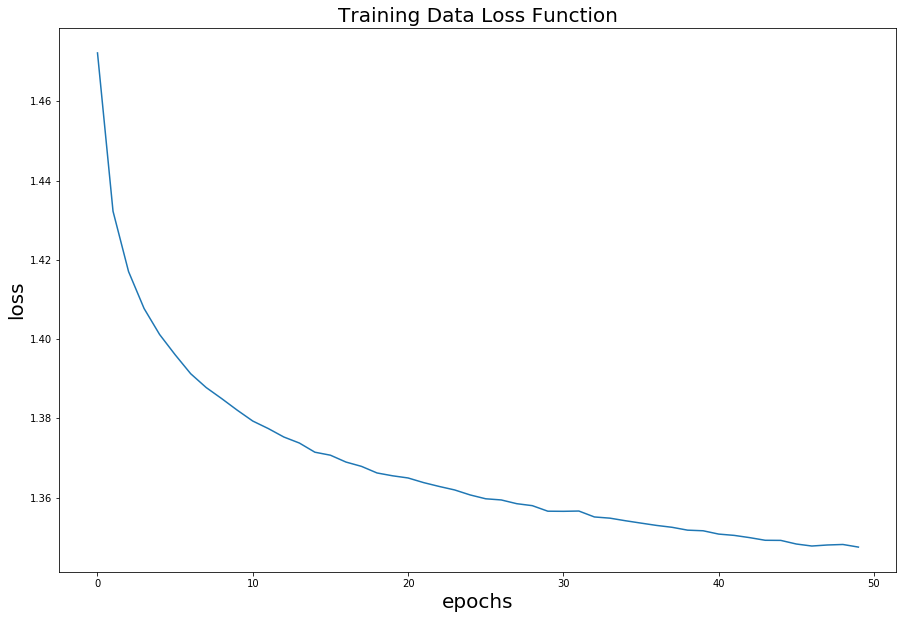

In [18]:
#look at the loss function
plt.figure(figsize=(15,10))
plt.plot(range(50), history_dict['loss'])
plt.title('Training Data Loss Function', size=20)
plt.xlabel('epochs', size=20)
plt.ylabel('loss', size=20)
plt.show()

In [64]:
#creates new sentences
def create_passage(model):
    #full passage string
    gen_sentence = ''

    #create sentence by pulling a random piece of text from the corpus
    start_ind = random.randint(0, len(sub_books_combined) - sentence_length - 1)
    sentence = sub_books_combined[start_ind: start_ind+sentence_length]
    gen_sentence += sentence
    print('original sentence: ', sentence)
    print('\n')
    
    #predict the next 500 characters 
    print(sentence, end="", flush=True)
    for i in range(250):
#     period_cnt = 0
#     while period_cnt != 2:
        #turn single sentence into model format
        x_pred = np.zeros((1, sentence_length, len(char_to_int)))
        #fill tensor with correspoinding values
        for k, c in enumerate(sentence):
            x_ind = char_to_int[c]
            x_pred[0, k, x_ind] = 1

        #predict next character - returns predicted probabilities
        prob_c = model.predict(x_pred, verbose=0)[0]
        #turn to float64 - mulitnomial gives error otherwise
        prob_c = np.asarray(prob_c).astype('float64')
        #sample from the probability - try out difference softmax temperature values - 0.5 produced best results
        log_prob = np.log(prob_c) / 0.5
        exp_prob = np.exp(log_prob)
        pred_prob = exp_prob/np.sum(exp_prob)
        #sample from new probability distribution
        p = np.random.multinomial(1, pred_prob, 1) 
        #get the probability position
        prob_ind = np.argmax(p)

        #turn prediction into a character
        next_c = int_to_char[prob_ind]
#         if next_c == '.':
#             period_cnt += 1
        #add character to generated sentence
        gen_sentence += next_c
        #get new sentence by sliding to index of sentence
        sentence = sentence[1:]+next_c
        print(next_c, end="", flush=True)

  
    return gen_sentence

In [21]:
#test out creating a passage using some of the passage within the books
print(create_passage(model))

original sentence:  ic; but, however this may be, i am prepared to sub
ic; but, however this may be, i am prepared to subsidier and constant than the tear of the designs of the house i have the consideration of the man something when they say that he would ever take him to be the hand with the profession of the thing he said to the consideration of such words that the strange are excepting to engage them his course at the pains of the subjects of the lower army was a second means, and understanding him to be short to be presented the point of the street and at the consideration of which he was with the other thing


## load other saved model weights and architecture and predict

In [75]:
# load json and create model architecture
architecture_path = "models/round8/model_8_architecture.json"
json_file = open(architecture_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
path = "models/round8/model_8.h5"
loaded_model.load_weights(path)
print("\n Loaded model from disk: ", path)
create_passage(loaded_model)
print()


 Loaded model from disk:  models/round8/model_8.h5
original sentence:  to the balance with health, than they do with this


to the balance with health, than they do with this feeling discovering the trick that with the great face of a little who was made out we are here. the doveral as some other sight of discretion the man of the supply it is no account of his head and a same white of the man had a place of her perfect 
